In [136]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

signal = pd.read_pickle("SignalMC.pkl")
bkgnd = pd.read_pickle("sidebands.pkl")

In [137]:
signal['signal/bkgnd'] = 1
bkgnd['signal/bkgnd'] = 0

In [138]:
df = pd.concat([signal,bkgnd], ignore_index=True)

In [139]:
#df = df.sample(frac=1).reset_index(drop=True) #rows in random order

In [140]:
df.head(5)

,Bpt,kpt,PDL,prob,BMass,DiMuMass,cosA,signLxy,signal/bkgnd
0,26.680304,11.619227,0.021847,0.748338,5.312783,3.538398,0.999972,15.482615,1
1,10.257165,3.517378,0.018031,0.967825,5.333508,1.616260,0.993626,7.343916,1
2,17.177292,2.610023,0.075210,0.086362,5.291852,4.585297,0.999993,45.554184,1
3,20.117249,3.583837,0.038395,0.333149,5.231747,2.684836,0.999318,24.436850,1
4,45.658031,4.257549,0.007641,0.372221,5.256309,4.134099,0.999891,7.496773,1


In [141]:
df = df.drop(['BMass', 'DiMuMass'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14758 entries, 0 to 14757
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bpt           14758 non-null  float32
 1   kpt           14758 non-null  float32
 2   PDL           14758 non-null  float32
 3   prob          14758 non-null  float32
 4   cosA          14758 non-null  float32
 5   signLxy       14758 non-null  float32
 6   signal/bkgnd  14758 non-null  int64  
dtypes: float32(6), int64(1)
memory usage: 461.3 KB


**FEATURES AND LABELS**

In [142]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus signal/bkgnd
train_y = df['signal/bkgnd'] #label = signal/bkgnd

In [160]:
#SIGNAL
signal_x = signal.drop(['signal/bkgnd','BMass', 'DiMuMass'], axis=1)
signal_y = signal['signal/bkgnd']

In [144]:
#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd','BMass', 'DiMuMass'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

In [145]:
#SAMPLING DATA
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.2, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

**XGBClassifier**

In [146]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', max_depth = 3, learning_rate=0.3)
#fit = training
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [147]:
predict_signal = model.predict(test_signal_x)
print(np.round(accuracy_score(test_signal_y,predict_signal)*100, 2),'%')

94.64 %


In [148]:
predict2 = model.predict(test_x)
print(np.round(accuracy_score(test_y,predict2)*100, 2),'%')

95.97 %


In [149]:
predict3 = model.predict(train_x)
print(np.round(accuracy_score(train_y,predict3)*100, 2),'%')

97.54 %


In [150]:
predict_prob = model.predict_proba(test_signal_x)
#converting prob values to list
df_prob = pd.DataFrame(predict_prob)
s_prob_signal = df_prob[df_prob.columns[1]] 
list_prob_signal = s_prob_signal.values.tolist()

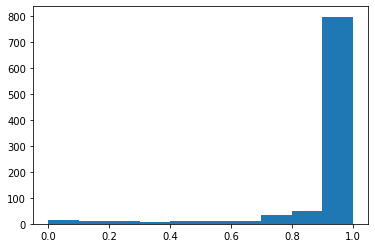

In [151]:
hist_signal = plt.hist(list_prob_signal, range=(0,1))

In [152]:
predict_prob_bkgnd = model.predict_proba(test_bkgnd_x)
df_prob_bkgnd = pd.DataFrame(predict_prob_bkgnd)
s_prob_bkgnd = df_prob_bkgnd[df_prob_bkgnd.columns[1]] 
list_prob_bkgnd = s_prob_bkgnd.values.tolist()

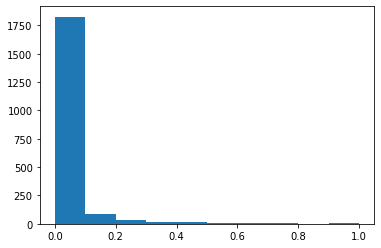

In [153]:
hist_bkgnd = plt.hist(list_prob_bkgnd, range=(0,1))

Text(0.5, 1.0, 'Signal vs Bkgnd (XGB)')

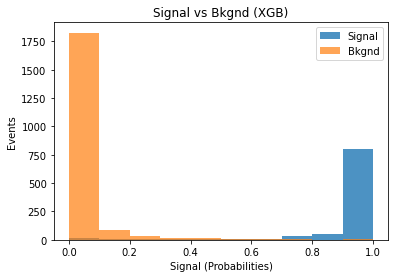

In [154]:
plt.hist(list_prob_signal, range=(0,1), alpha=0.8,label='Signal')
plt.hist(list_prob_bkgnd, range=(0,1), alpha=0.7, label='Bkgnd')
plt.legend(loc='upper right')
plt.xlabel('Signal (Probabilities)')
plt.ylabel('Events')
plt.title('Signal vs Bkgnd (XGB)')

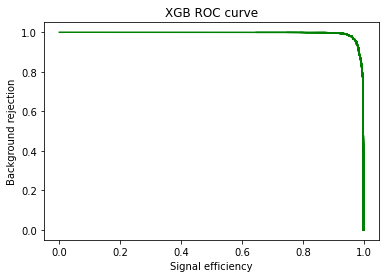

In [155]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

list_prob_signal = sorted(list_prob_signal)
list_prob_bkgnd = sorted(list_prob_bkgnd)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
efficiency = []
background_rejection = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    accepted_signal = len(list_prob_signal)
    rejected_background = 0


    for i, v in enumerate(list_prob_signal):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            accepted_signal-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(list_prob_signal)-1:
            accepted_signal=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(list_prob_bkgnd):
        if cut<=m:
            rejected_background+=i
            break
        if i==len(list_prob_bkgnd)-1:
            rejected_background=len(list_prob_bkgnd)
    
    #ALMACENA EN LA LISTA
    efficiency.append(accepted_signal/len(list_prob_signal))
    background_rejection.append(rejected_background/len(list_prob_bkgnd))

    xgbst = plt.plot(efficiency, background_rejection)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('XGB ROC curve')

In [168]:
probtrainS = model.predict_proba(train_signal_x)
#converting prob values to list
df_probtrainS = pd.DataFrame(probtrainS)
s_probtrainS = df_probtrainS[df_probtrainS.columns[1]] 
list_probtrainS = s_probtrainS.values.tolist()

In [169]:
probtrainB = model.predict_proba(train_bkgnd_x)
df_probtrainB = pd.DataFrame(probtrainB)
s_probtrainB = df_probtrainB[df_probtrainB.columns[1]] 
list_probtrainB = s_probtrainB.values.tolist()

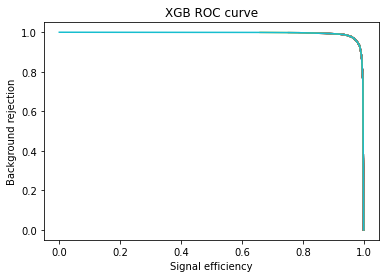

In [170]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

list_probtrainS = sorted(list_probtrainS)
list_probtrainB = sorted(list_probtrainB)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
efficiency2 = []
background_rejection2 = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    accepted_signal = len(list_probtrainS)
    rejected_background = 0


    for i, v in enumerate(list_probtrainS):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            accepted_signal-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(list_probtrainS)-1:
            accepted_signal=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(list_probtrainB):
        if cut<=m:
            rejected_background+=i
            break
        if i==len(list_prob_bkgnd)-1:
            rejected_background=len(list_probtrainB)
    
    #ALMACENA EN LA LISTA
    efficiency2.append(accepted_signal/len(list_probtrainS))
    background_rejection2.append(rejected_background/len(list_probtrainB))

    xgbst2 = plt.plot(efficiency2, background_rejection2)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('XGB ROC curve')

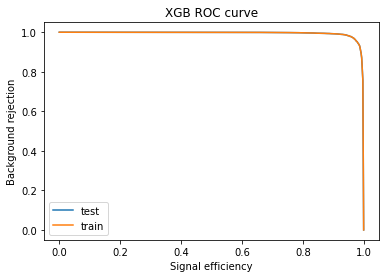

In [172]:
xgbst = plt.plot(efficiency, background_rejection, label='test')
xgbst2 = plt.plot(efficiency2, background_rejection2, label='train')
plt.xlabel('Signal efficiency')
plt.ylabel('Background rejection')
plt.title('XGB ROC curve')
plt.legend(loc='lower left')
plt.show()

ROC AUC=  0.990232842797793


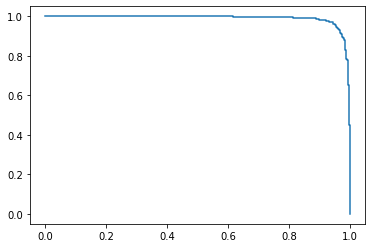

In [156]:
model_predict1 = model.predict_proba(test_x)
model_predict1 = model_predict1[:,1]
auc_score1 = roc_auc_score(test_y, model_predict1)
fpr1, tpr1, _ = roc_curve(test_y, model_predict1)
testp = plt.plot(tpr1, 1-fpr1, label='test')
print('ROC AUC= ', auc_score1)
plt.show()

ROC AUC=  0.9962129778084459


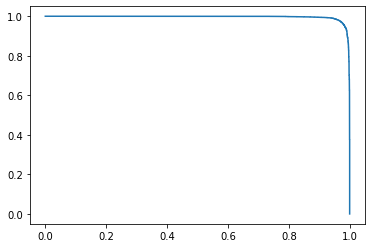

In [157]:
model_predict2 = model.predict_proba(train_x)
model_predict2 = model_predict2[:,1]
auc_score = roc_auc_score(train_y, model_predict2)
fpr2, tpr2, _ = roc_curve(train_y, model_predict2)
trainp = plt.plot(tpr2, 1-fpr2, label='train')
print('ROC AUC= ', auc_score)
plt.show()

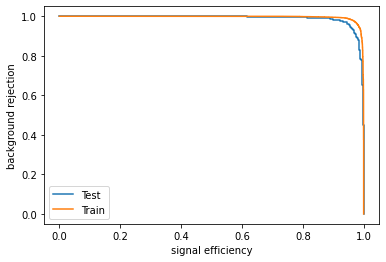

In [167]:
plt.plot(tpr1, 1-fpr1, label='Test')
plt.plot(tpr2, 1-fpr2, label='Train')
plt.legend(loc='lower left')
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.show()